<a href="https://colab.research.google.com/github/cowsilver57/Project/blob/main/%EB%9E%9C%EB%94%A9%ED%81%B4%EB%9F%BD4_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
data = pd.read_csv('/content/preprocessed_data.csv')

In [29]:
data['term'] = data['term'].apply(lambda x: int(x.split()[0]) if pd.notnull(x) else x)

# 3. 모델링 전 전처리

## 3-1. 오버샘플링

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


# 클래스 별로 샘플 수 계산

#0 = 체납
minority_class = data[data['loan_status'] == 0]
#1 = 완납
majority_class = data[data['loan_status'] == 1]

print("Minority class samples:", len(minority_class))
print("Majority class samples:", len(majority_class))

# 적절한 비율로 오버샘플링 수행
minority_class_oversampled = resample(minority_class,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=42)

# 오버샘플링된 데이터를 기존 데이터와 합치기
data_oversampled = pd.concat([majority_class, minority_class_oversampled])

print(data_oversampled.shape)

Minority class samples: 77352
Majority class samples: 316629
(633258, 29)


In [31]:
#0 = 체납
minority_class = data_oversampled[data_oversampled['loan_status'] == 0]
#1 = 완납
majority_class = data_oversampled[data_oversampled['loan_status'] == 1]

print("Minority class samples:", len(minority_class))
print("Majority class samples:", len(majority_class))

Minority class samples: 316629
Majority class samples: 316629


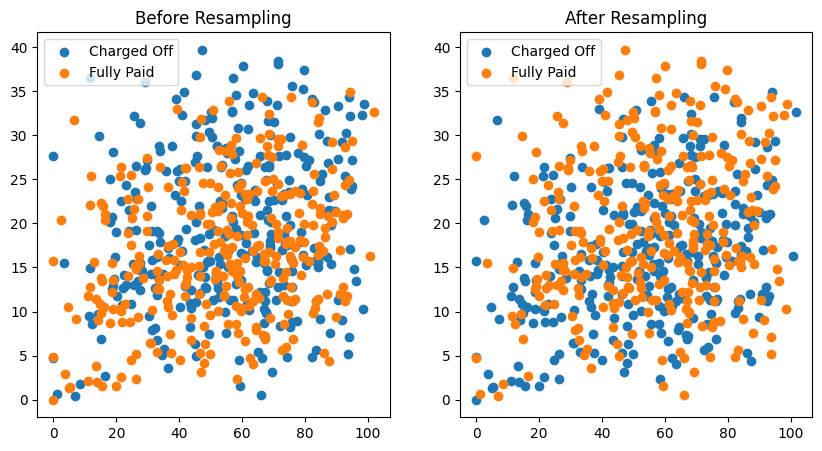

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

X1 = minority_class['revol_util'][:int(len(minority_class)*0.001)]
X2 = minority_class['dti'][:int(len(minority_class)*0.001)]

X3 = majority_class['revol_util'][:int(len(majority_class)*0.001)]
X4 = majority_class['dti'][:int(len(majority_class)*0.001)]

major2 = data_oversampled.loc[data_oversampled['loan_status']==0]
minor2 = data_oversampled.loc[data_oversampled['loan_status']==1]

XX1 = minor2['revol_util'][:int(len(minor2)*0.001)]
XX2 = minor2['dti'][:int(len(minor2)*0.001)]

XX3 = major2['revol_util'][:int(len(major2)*0.001)]
XX4 = major2['dti'][:int(len(major2)*0.001)]

# print(len(X1), len(X2), len(X3), len(X4))
# print(len(XX1), len(XX2), len(XX3), len(XX4))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(X1, X2, color='tab:blue', label='Charged Off') #체납
axes[0].scatter(X3, X4, color='tab:orange', label='Fully Paid') #완납

axes[1].scatter(XX1, XX2, color='tab:blue', label='Charged Off') #체납
axes[1].scatter(XX3, XX4, color='tab:orange', label='Fully Paid') #완납

axes[0].set_title('Before Resampling')
axes[0].legend()
axes[1].set_title('After Resampling')
axes[1].legend()

## 3-2. 수치형 변수 스케일링

데이터 분리

In [33]:
COL_NUM = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'pub_rec_bankruptcies']
COL_CAT = ['term', 'sub_grade', 'home_ownership', 'verification_status', 'address_0', 'address_1', 'address_2', 'address_3', 'address_4', 'address_5',
           'address_6', 'address_7', 'address_8', 'address_9', 'app_type_DIRECT_PAY', 'app_type_INDIVIDUAL', 'app_type_JOINT']

In [34]:
test = data_oversampled.drop('loan_status', axis=1)
size = int(len(test) * 0.8)

X_train = test.iloc[:size]
X_test = test.iloc[size:]

y_train = data_oversampled['loan_status'].iloc[:size]
y_test = data_oversampled['loan_status'].iloc[size:]

수치형 변수 스케일링

In [35]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train[COL_NUM+COL_CAT],
							                         y_train.values.ravel(),
								                       test_size=0.3,
							                         stratify=y_train.values.ravel())

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr[COL_NUM])

X_tr[COL_NUM] = scaler.transform(X_tr[COL_NUM])
X_val[COL_NUM] = scaler.transform(X_val[COL_NUM])
X_test[COL_NUM] = scaler.transform(X_test[COL_NUM])

<ipython-input-36-894467aa0314>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[COL_NUM] = scaler.transform(X_test[COL_NUM])


In [37]:
X_tr.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,address_3,address_4,address_5,address_6,address_7,address_8,address_9,app_type_DIRECT_PAY,app_type_INDIVIDUAL,app_type_JOINT
188867,-0.276866,-0.254098,-0.126411,-0.638064,-1.456194,-0.850199,-0.353871,-0.853337,-1.191083,-1.122951,...,0,0,0,0,0,0,0,0,1,0
253487,-0.754361,0.033797,-0.646068,-0.217014,-0.149897,-0.264257,-0.353871,-0.596999,-0.943871,0.483060,...,0,0,0,0,0,0,0,0,1,0
308617,-0.933421,-0.407935,-0.877645,-0.831044,-0.398542,-0.654885,1.595658,-0.679332,-0.704900,-1.292005,...,0,0,0,0,0,0,0,0,1,0
288156,-1.040858,-1.265027,-1.039136,-0.392452,0.325561,-0.459571,-0.353871,-0.534992,-0.630736,-0.784844,...,0,0,0,0,1,0,0,0,1,0
190936,-0.993108,-1.372713,-0.994055,-0.430346,-0.833975,-0.850199,-0.353871,-0.006935,0.176823,-0.446736,...,0,0,0,0,0,0,0,0,1,0


In [38]:
y_tr

array([1, 1, 0, ..., 0, 1, 1])

# 4. 모델링

## 4-1. XGBoost

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

modelXGB = XGBClassifier()
modelXGB.fit(X_tr, y_tr)

#예측 데이터 정의하기
y_val_pred = modelXGB.predict(X_val)

# 혼동 행렬 계산
confusion = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', confusion)
print('-'*50)

#정확도 계산
accuracy = accuracy_score(y_val, y_val_pred)
print('Accuracy:', accuracy)

# 재현율 계산
recall = recall_score(y_val, y_val_pred, average='macro')
print('Recall:', recall)

Confusion Matrix:
 [[34554 22439]
 [14070 80919]]
--------------------------------------------------
Accuracy: 0.7597807635114685
Recall: 0.7290812840959913


## 4-2. Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

modelRF = RandomForestClassifier(random_state=123)
modelRF.fit(X_tr, y_tr)

y_val_pred = modelRF.predict(X_val)

# 혼동 행렬 계산
confusion = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', confusion)
print('-'*50)

#정확도 계산
accuracy = accuracy_score(y_val, y_val_pred)
print('Accuracy:', accuracy)

# 재현율 계산
recall = recall_score(y_val, y_val_pred, average='macro')
print('Recall:', recall)

Confusion Matrix:
 [[50706  6287]
 [ 7568 87421]]
--------------------------------------------------
Accuracy: 0.9088378886973457
Recall: 0.9050079121028306


## 4-3. Logistic Regressor

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

model = LogisticRegression(random_state=123)
model.fit(X_tr, y_tr)

y_val_pred = model.predict(X_val)

# 성능 평가
# 혼동 행렬 계산
confusion = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', confusion)
print('-'*50)

#정확도 계산
accuracy = accuracy_score(y_val, y_val_pred)
print('Accuracy:', accuracy)

# 재현율 계산
recall = recall_score(y_val, y_val_pred, average='macro')
print('Recall:', recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[31921 25072]
 [14016 80973]]
--------------------------------------------------
Accuracy: 0.7428116487478781
Recall: 0.7062661995470577


##4-4. Naive Bayes

In [42]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

# BernoulliNB 모델 생성
model_BernoulliNB = BernoulliNB()

# 학습 데이터에 모델 훈련
model_BernoulliNB.fit(X_tr, y_tr)

# 검증 데이터 예측
y_val_pred = model_BernoulliNB.predict(X_val)

# 혼동 행렬 계산
confusion = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', confusion)
print('-'*50)

# 정확도 계산
accuracy = accuracy_score(y_val, y_val_pred)
print('Accuracy:', accuracy)

# 재현율 계산
recall = recall_score(y_val, y_val_pred, average='macro')
print('Recall:', recall)

Confusion Matrix:
 [[32986 24007]
 [17102 77887]]
--------------------------------------------------
Accuracy: 0.7295140213972707
Recall: 0.6993654660814472


최종 결과
* 해당 프로젝트에서는 체납자를 정확하게 분류하는 것이 중요하기 때문에 recall 값을 평가 기준으로 설정

# 5. 비즈니스 전략

* 이자율 인하 전략
---
1, 8, 9 지역 대출자에게 최대 20,000달러 내에서 대출 이자율을 인하

* 특별 심사 전략
---
연소득 40,000 달러 이하인 저소득자를 위해 별도의 대출 심사기준 마련

* 보상 전략
---
정상적으로 상환하고 있거나 상환 이력 개선된 고객에 대한 추가 혜택이나 리워드 프로그램을 도입하여 상환 장려
